# Spectral Clustering (RBF Under Construction)

Z. W. Miller - Copyright 2018

In [3]:
import numpy as np
import random
import matplotlib.pyplot as plt
import pandas as pd
import math
import scipy
%matplotlib inline
plt.style.use('seaborn')

In [4]:
import numpy as np
import sklearn
import matplotlib
import pandas as pd
import sys
libraries = (('Matplotlib', matplotlib), ('Numpy', np), ('Pandas', pd))

print("Python Version:", sys.version, '\n')
for lib in libraries:
    print('{0} Version: {1}'.format(lib[0], lib[1].__version__))

Python Version: 3.6.2 |Anaconda custom (64-bit)| (default, Sep 21 2017, 18:29:43) 
[GCC 4.2.1 Compatible Clang 4.0.1 (tags/RELEASE_401/final)] 

Matplotlib Version: 2.0.2
Numpy Version: 1.12.1
Pandas Version: 0.20.3


In [34]:
import numpy as np
import pandas as pd
import sys
sys.path.append('../..')
from zwml.clustering import kmeans

class spectral_clustering:
    
    def __init__(self, k=3, connectivity=20, svd_dims=3, affinity='neighbors', bandwidth=1.):
        """
        Spectral clustering is KMeans but with special connectivity restrictons.
        To measure connectivity, we will use nearest neighbors or a kernel estimation.
        That extra dimension of connectivity will be the basis for the clustering.
        ---
        KWargs:
        k: number of cluster to look for
        connectivity: how many neighbors to use in connectivity matrix
        svd_dims: When doing dimensionality reduction on connectivity,
        how many dimensions to keep
        affinity: type of connectivity to use ("neighbors", "rbf")
        bandwidth: if using RBF, sets width of assumed gaussian kernel
        """
        self.k = k
        self.connect = connectivity
        self.dims = svd_dims
        if affinity in ['neighbors', 'rbf']:
            self.affinity_type = affinity
        else:
            print("Not a valid affinity type, default to 'neighbors'.")
            self.affinity_type = 'neighbors'
        self.bandwidth = bandwidth
    
    def rbf_kernel(self, x1, x2, sig=1.):
        """
        Returns the rbf affinity between two points (x1 and x2),
        for a given bandwidth (standard deviation).
        ---
        Inputs: 
            x1; point 1(array)
            x2; point 2(array)
            sig; standard deviation (float)
        """
        diff = np.sqrt(np.sum((x1-x2)**2))
        norm = 1/(np.sqrt(2*np.pi*sig**2))
        return norm*np.exp(-diff**2/(2*sig**2))
    
    def compute_distance_between_all_points(self, pt1, pts, connectivity=None):
        """
        Measures the connectivity between points. If neighbors, it finds
        the requested number of neighbors and in the matrix of "does this
        data point know that one" sets it to 1. Otherwise, it's 0.
        If rbf, creates a matrix measuring the "extent" of neighborhood
        by measuring the gaussian probability between the points.
        ---
        Input: data point (np arrays)
        Output: connectivity between eac ponts and all others
        """
        if self.affinity_type == 'neighbors':
            x = np.sqrt(np.sum((pt1 - pts)**2, axis=1))
            idxs = x.argsort()[:connectivity]
            filt = np.ones(len(x), dtype=bool)
            filt[idxs] = False
            x[filt] = 0.
            x[~filt] = 1.
        elif self.affinity_type == 'rbf':
            x = []
            for p in pts:
                x.append(self.rbf_kernel(pt1, p, sig=self.bandwidth))
        return x
    
    def fit(self, X):
        """
        Measures connectivity between points. Does a dimensionality
        reduction on the connectivity matrix. Fits a KMeans model
        to the reduced space, labeling each point by it's cluster 
        in this new "connection measured" space.
        """
        X = self.pandas_to_numpy(X)
        self.original_data = np.copy(X)
        self.similarity = np.array([self.compute_distance_between_all_points(p,X, connectivity=self.connect) for p in X])
        self.similarity /= max(self.similarity.ravel())
        self.U, self.Sigma, self.VT = self.do_svd(self.similarity)
        self.kmeans = kmeans(k=self.k)
        self.kmeans.fit(self.U)
        
    def fit_predict(self, X):
        """
        Trains on and then predicts from the original training data
        """
        self.fit(X)
        return self.predict(X)
        
    def transform_to_svd_space(self,X):
        """
        Converts a new point into the SVD space
        using the VT matrix from sVD
        """
        sig_inv = np.linalg.inv(self.Sigma)
        return np.dot(X, self.VT.T)
    
    def predict(self, X):
        """
        Computes connectivity between new point and all training points,
        converts the new points into the reduced dimensionality space,
        predicts based on the KMeans model previously trained.
        """
        X = self.pandas_to_numpy(X)
        sim_space = [self.compute_distance_between_all_points(p,self.original_data, connectivity=self.connect) for p in X]
        transformed_X = np.array([self.transform_to_svd_space(x) for x in sim_space])
        return self.kmeans.predict(transformed_X)
    
    def do_svd(self, similarity):
        """
        Uses the numpy SVD method to do
        singular value decomposition on the
        similarity/connectivity matrix.
        """
        dims = self.dims
        U, Sigma, VT = np.linalg.svd(similarity)
        VT = VT[:dims,:]
        U = U[:,:dims]
        Sigma = np.diag(Sigma[:dims])
        return U, Sigma, VT
        
    def plot_similarity_matrix(self):
        """
        Plots the connectivity/similarity matrix.
        """
        plt.figure(dpi=200)
        plt.imshow(self.similarity, cmap=plt.cm.Blues)
        plt.xlabel("Point ID", fontsize=16)
        plt.ylabel("Point ID", fontsize=16)
        plt.title("Similarity Matrix (1 for neighbors, 0 for not)", fontsize=16);
        plt.colorbar(cmap=plt.cm.Blues);
        
    def pandas_to_numpy(self, x):
        """
        Checks if the input is a Dataframe or series, converts to numpy matrix for
        calculation purposes.
        ---
        Input: X (array, dataframe, or series)
        
        Output: X (array)
        """
        if type(x) == type(pd.DataFrame()) or type(x) == type(pd.Series()):
            return x.as_matrix()
        if type(x) == type(np.array([1,2])):
            return x
        return np.array(x)

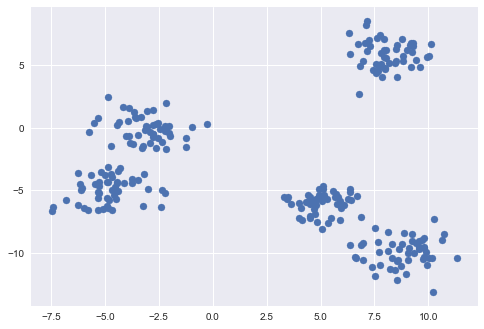

In [35]:
def get_data(n_clust = 3):
    X1 = np.random.normal(-5,1,50).reshape(-1,1)
    y1 = np.random.normal(-5,1,50).reshape(-1,1)
    for _ in range(n_clust-1):
        X2 = np.random.normal(np.random.randint(-10,10),1,50).reshape(-1,1)
        y2 = np.random.normal(np.random.randint(-10,10),1,50).reshape(-1,1)
        X1 = np.vstack((X1,X2)).reshape(-1,1)
        y1 = np.vstack((y1,y2)).reshape(-1,1)
    X = np.hstack((X1,y1))
    return X

X = get_data(n_clust=5)
#np.random.shuffle(X)
plt.scatter(X[:,0],X[:,1]);

In [48]:
sc = spectral_clustering(k=5)
preds = sc.fit_predict(X)

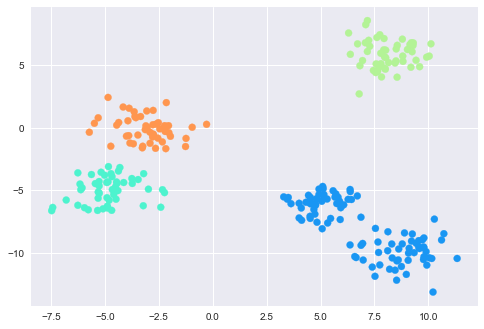

In [49]:
plt.scatter(X[:,0],X[:,1],c=plt.cm.rainbow(0.2*preds.ravel()));

Let's make sure this is working on new data. For my dataset (this will change if you re-run), the cluster around (-5,-5) is labeled as cluster 1. Let's see if a new point at (-5,-5) is put into cluster 1 correctly.

In [50]:
for x, y in zip(X[:10],preds[:10]):
    print("Point at: ", x)
    print("Cluster Num: ", y)
print("---")
print("At [-5, -5], should be same cluster.")
print("Prediction is: ",sc.predict([[-5,-5]]))

Point at:  [-4.39540414 -5.01143823]
Cluster Num:  [2]
Point at:  [-4.51500432 -4.73042702]
Cluster Num:  [2]
Point at:  [-5.25683128 -5.21869007]
Cluster Num:  [2]
Point at:  [-4.91434967 -4.36277415]
Cluster Num:  [2]
Point at:  [-4.3707359  -3.44627365]
Cluster Num:  [2]
Point at:  [-3.72828097 -4.44123399]
Cluster Num:  [2]
Point at:  [-5.76840138 -6.54623963]
Cluster Num:  [2]
Point at:  [-4.30416327 -3.1654896 ]
Cluster Num:  [2]
Point at:  [-6.11628976 -4.94235961]
Cluster Num:  [2]
Point at:  [-5.01376213 -3.78117962]
Cluster Num:  [2]
---
At [-5, -5], should be same cluster.
Prediction is:  [[2]]


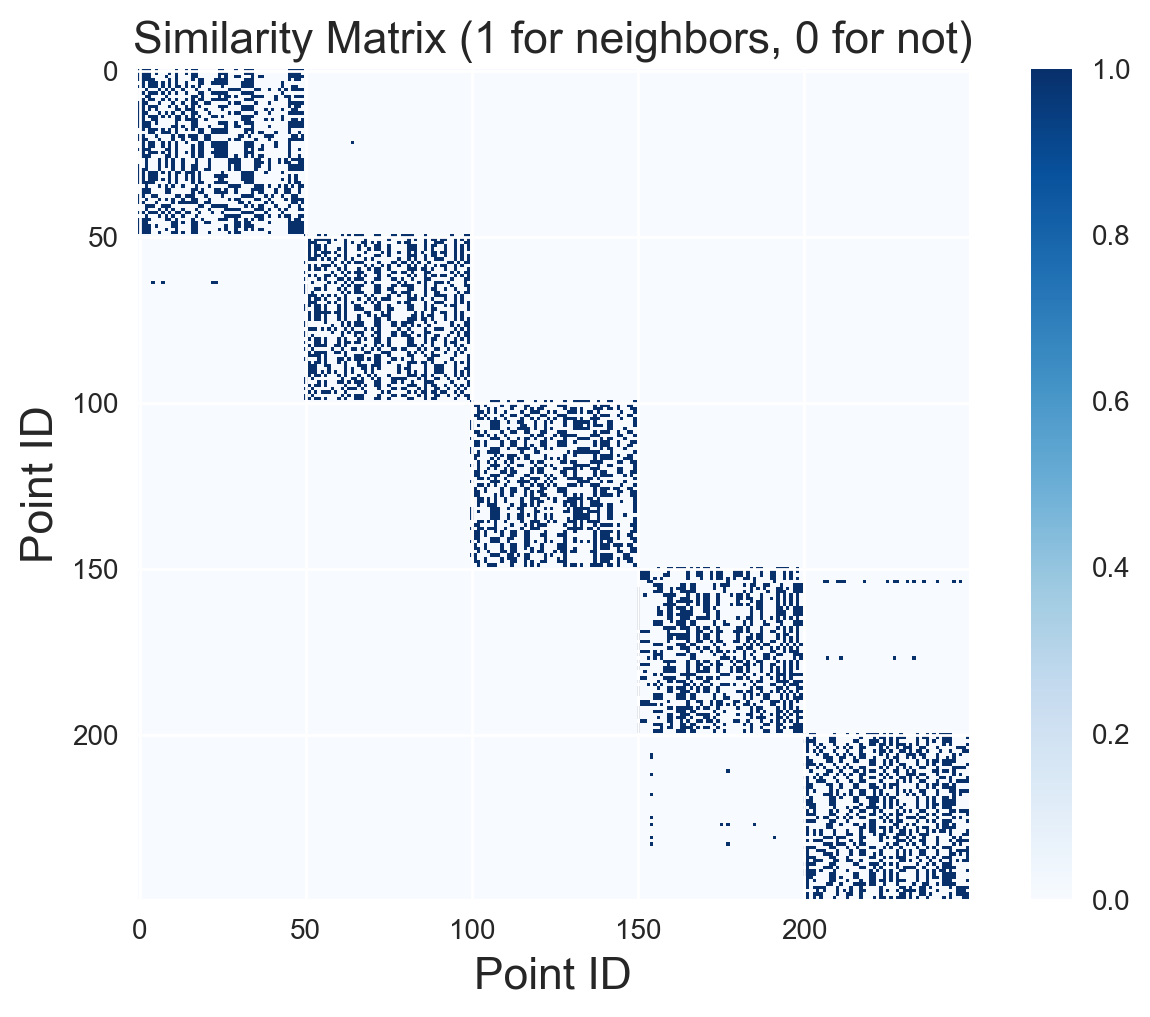

In [51]:
sc.plot_similarity_matrix()

## Now let's play with some circular data that KMeans can't handle

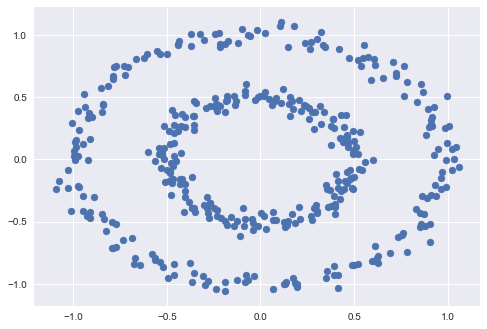

In [52]:
from sklearn.datasets import make_circles
X, y = make_circles(n_samples=400, factor=0.5, random_state=0, noise=0.05)
plt.scatter(X[:,0],X[:,1]);

In [53]:
sc = spectral_clustering(k=2, affinity='neighbors')
sc.fit(X)

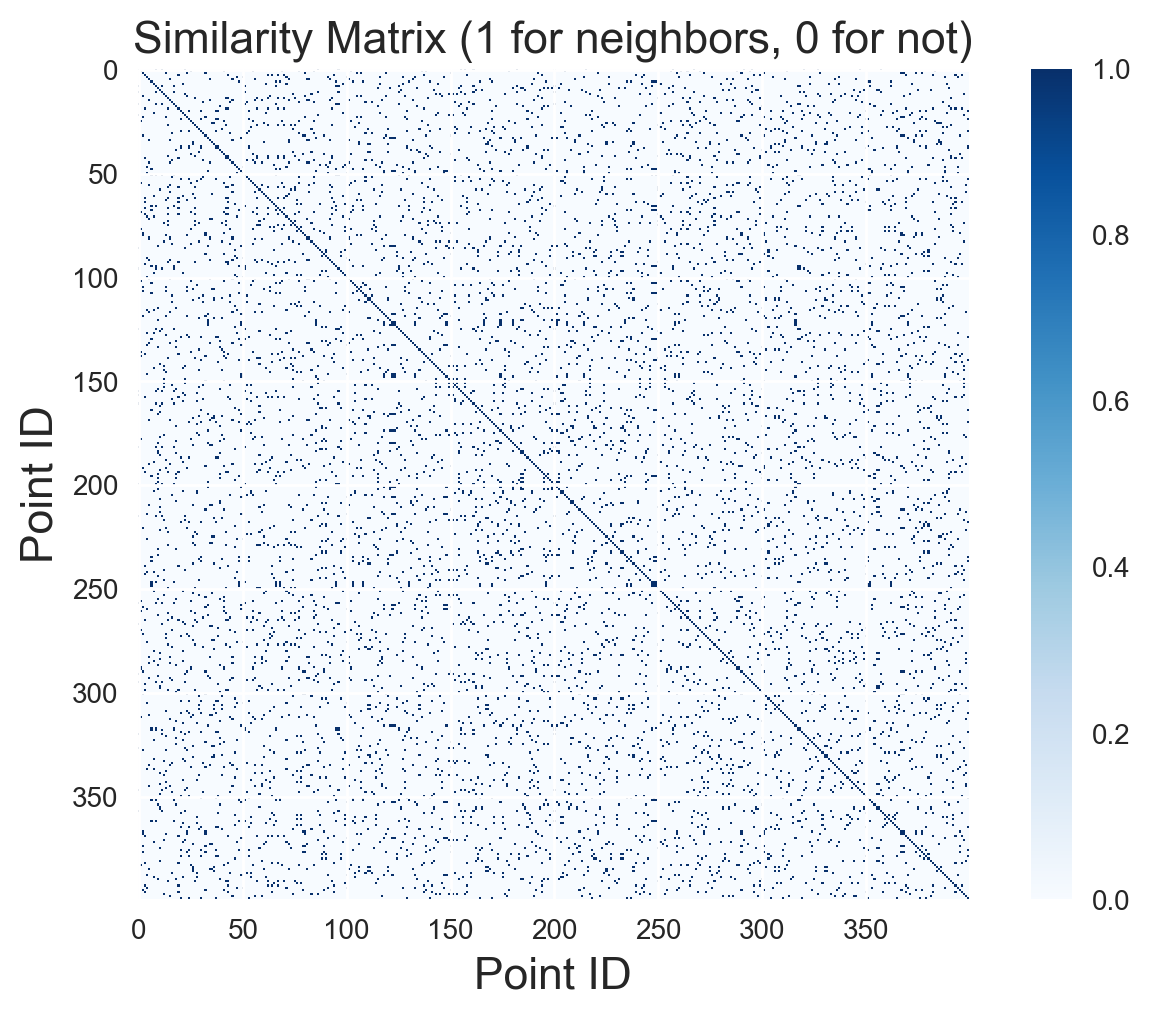

In [54]:
sc.plot_similarity_matrix()

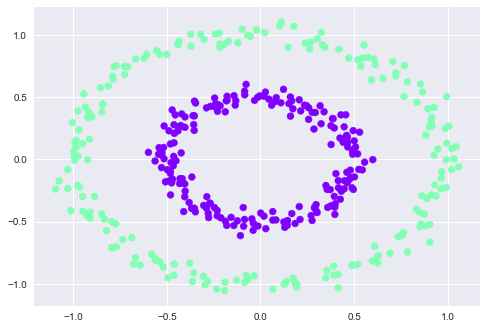

In [55]:
preds = sc.predict(X)
plt.scatter(X[:,0],X[:,1],c=plt.cm.rainbow(0.5*preds.ravel()));

## Now let's play with the RBF Kernel - UNDER CONSTRUCTION

In [61]:
sc = spectral_clustering(k=2, affinity='rbf', bandwidth=0.3, svd_dims=10)
sc.fit(X)

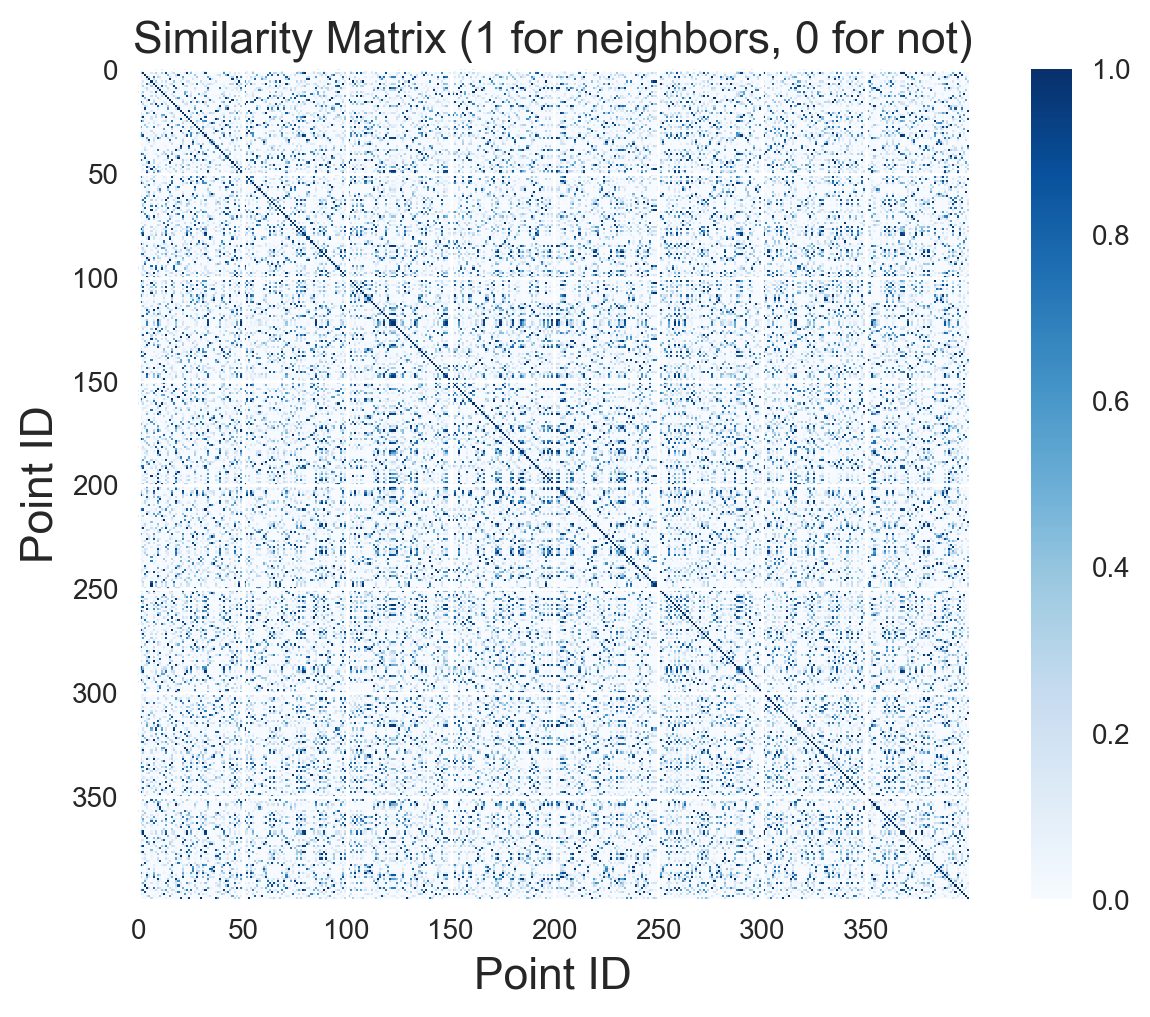

In [62]:
sc.plot_similarity_matrix()

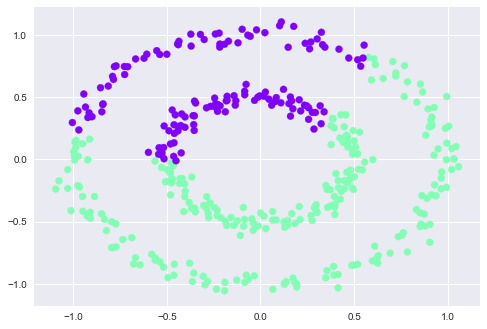

In [63]:
preds = sc.predict(X)
plt.scatter(X[:,0],X[:,1],c=plt.cm.rainbow(0.5*preds.ravel()));